## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
counts_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/ecol/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/AS_stats/ecol/'
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
mutation = 'efp'
samp_num = '2'

# figure out if the notebook has already been done for this dataset and only run the
# visualizations. 
if os.path.isfile(save_path + "AS_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data.

In [4]:
# Load in the count positions data.
data_mutant, names_mutant = kat.load_count_positions(mutation+"_"+samp_num+"_counts.csv",counts_path)
data_control, names_control = kat.load_count_positions("control_"+ samp_num +"_counts.csv",counts_path)

In [5]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
mutant_list = []
control_list = []
gene_list = []
length_list = []
for tr_m, tr_c, gene_name in zip(data_mutant, data_control, names_mutant):
    if len(tr_m) > 100 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
        mutant_list.append(tr_m)
        control_list.append(tr_c)
        gene_list.append(gene_name)
        length_list.append(len(tr_m))

## Finding the quantiles for all transcripts

In [6]:
def get_quantile(array):
    length = len(array)
    quant = int(length/4)
    return(array[0:quant], array[quant*3:length])

In [7]:
stalling_scores = []
for i in mutant_list:
    five_end, three_end = get_quantile(i)
    stalling_scores.append(((sum(five_end)-sum(three_end))/sum(i)) * 100)

In [8]:
df = pd.DataFrame(list(zip(gene_list, length_list, stalling_scores)))
df.columns = ["gene_ID", "gene_length", "stall_score"]
df.sort_values(by = "stall_score", inplace = True)
df = df.reset_index()

In [9]:
# Load up the target gene names. 
PPP_table = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/data_tables/' + 'polyproline_motifs.csv')

In [10]:
# Correct the column headings and rows for the polyproline table. 
PPP_table.columns = PPP_table.iloc[2]
PPP_table = PPP_table.drop([0,1,2])

# Remove the many unecessary columns from the polyproline data
PPP_table = pd.DataFrame(PPP_table.Gene.unique(), columns = ["Gene"])

# Merge the ecoli AS table with the list of gene names
PPP_as_table = pd.merge(df, PPP_table, how='inner', right_on='Gene', left_on='gene_ID')

In [11]:
# Several genes have multiple polyproline motifs and thus appear multiple times in the PPP table
# Keep only one copy of each gene in the PPP table. 
PPP_as_table.drop_duplicates(subset ="Gene",keep = "first", inplace = True) 

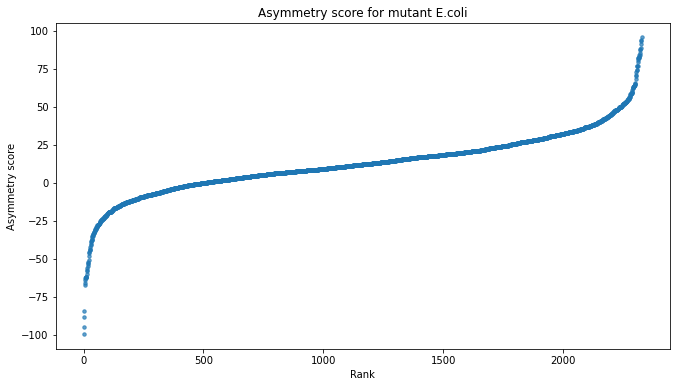

Text(0.5, 1.0, 'Asymmetry score for mutant E.coli')

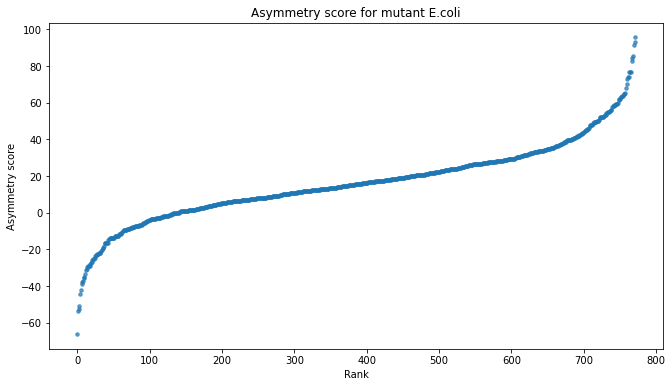

In [12]:
# Plot the AS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df.stall_score))), df.stall_score, s=12, alpha = 0.7)
plt.ylabel("Asymmetry score")
plt.xlabel("Rank")
plt.title("Asymmetry score for mutant E.coli")
plt.show()
# Plot the AS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(PPP_as_table.stall_score))), PPP_as_table.stall_score, s=12, alpha = 0.7)
plt.ylabel("Asymmetry score")
plt.xlabel("Rank")
plt.title("Asymmetry score for mutant E.coli")

In [13]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df["gene_length"]:
    if i < 220:
        size_groups.append(1)
    elif i >= 220 and i < 600:
        size_groups.append(2)
    elif i >= 600:
        size_groups.append(3)
df["size_groups"] = size_groups

In [14]:
# Find all of the transcripts with a AS stat above a certain threshold and group them by gene ID
group = df[(df.stall_score > 77) & (df['size_groups'] == 2)].groupby('gene_ID')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['stall_score'].unique())

In [15]:
len(diff_dist)

6

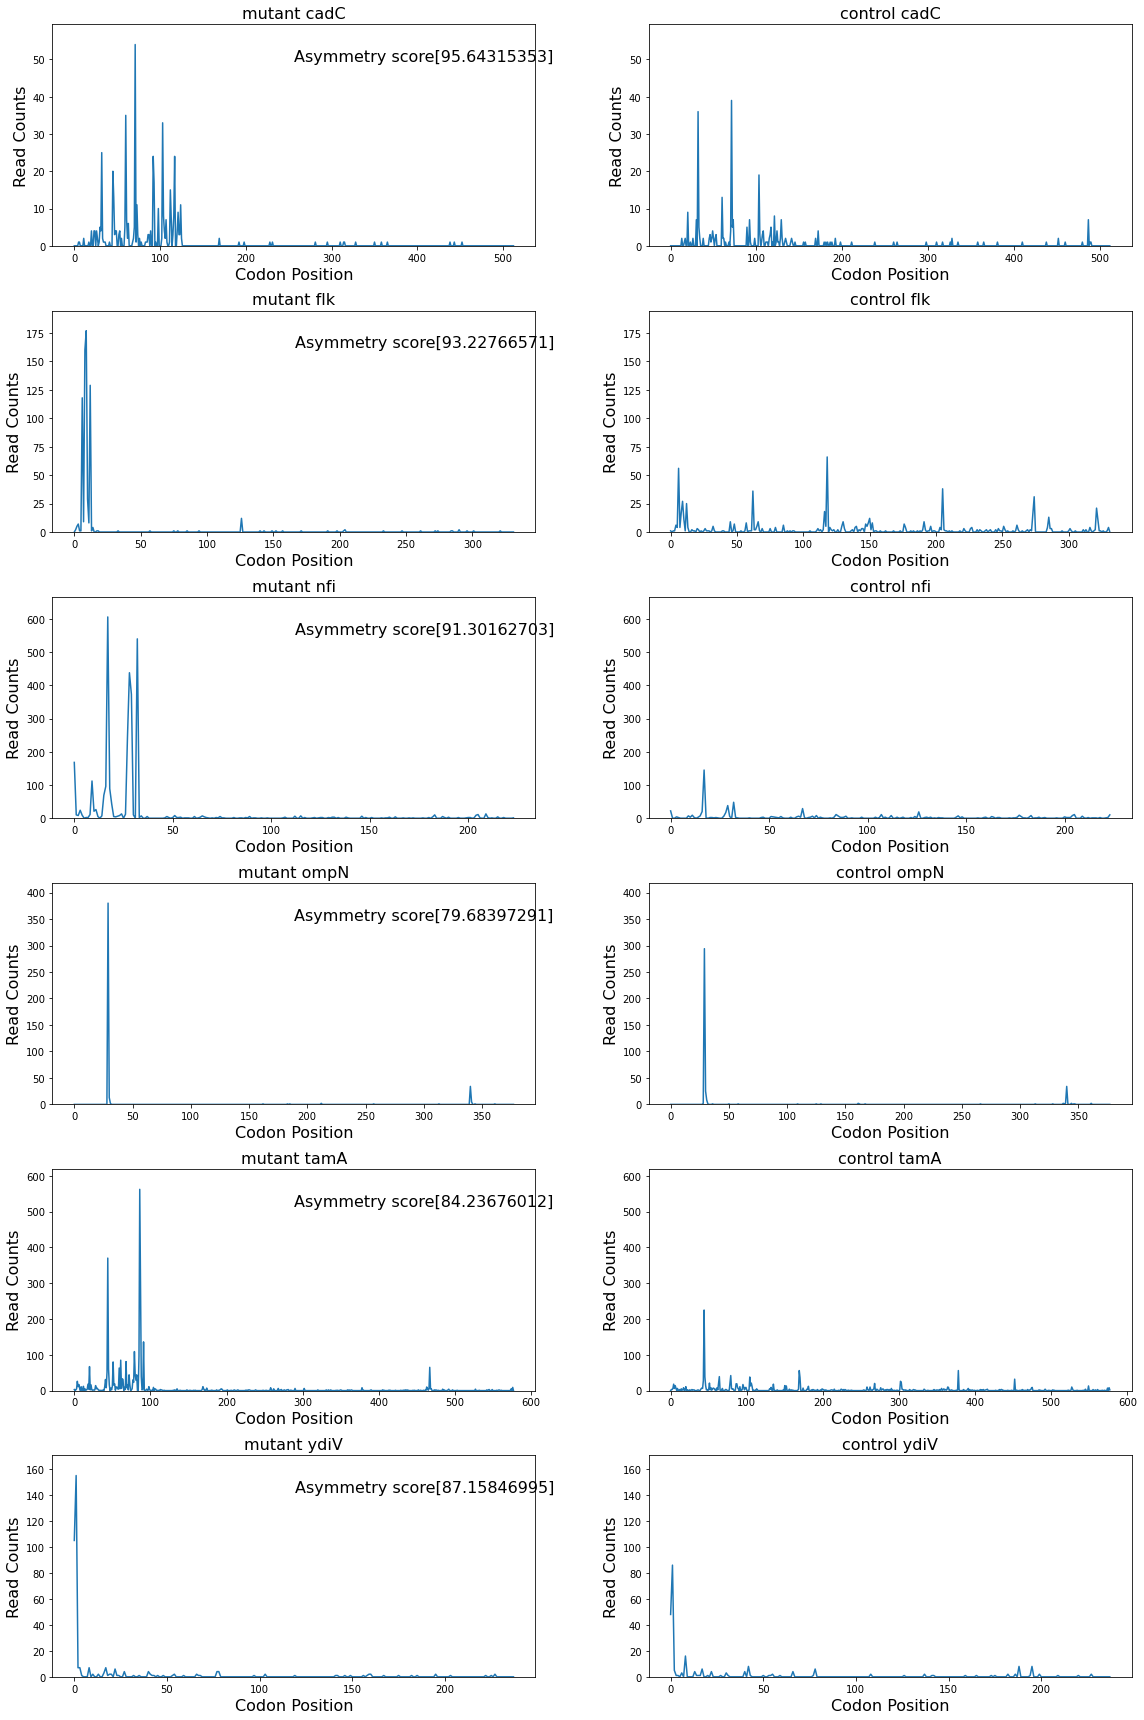

In [31]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = kat.big_dif(diff_dist, gene_list, mutant_list, control_list, figsize = (16,len(diff_dist)*4), fontsize = 16, stat_name = "Asymmetry score")

In [17]:
max_AS = 50
N_cats = 2
ratios_ecol, sections_ecol = kat.determine_enrichment(PPP_as_table, df, max_AS, N_cats, stat = "stall_score")

In [18]:
ratios_ecol

[0.3002244668911336, 0.4026258205689278, 0.5909090909090909]

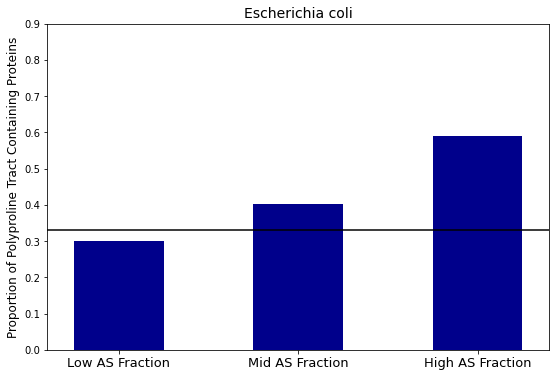

In [21]:
expected = len(PPP_as_table.stall_score)/len(df.stall_score)
figure(figsize = (9,6))
plt.bar([1,2,3],ratios_ecol, color = "darkblue",width = 0.5,
       tick_label = ["Low AS Fraction", "Mid AS Fraction", "High AS Fraction"])
plt.xticks(fontsize = 13)
plt.xlim(0.6,3.4)
plt.ylim(0, 0.9)
plt.ylabel("Proportion of Polyproline Tract Containing Proteins", fontsize = 12)
plt.title("Escherichia coli", fontsize = 14)
plt.plot([0,4],[expected,expected], color = "black")

In [22]:
kat.det_p_values(PPP_as_table, df, sections_ecol, stat = "stall_score")

[0.10798243009128121, 0.0019658976377301242, 7.527083452162317e-07]

## Looking at the cumulative distributions

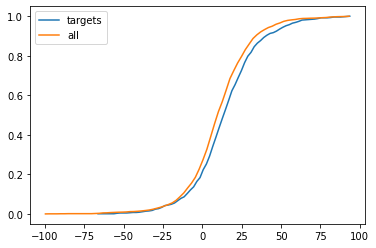

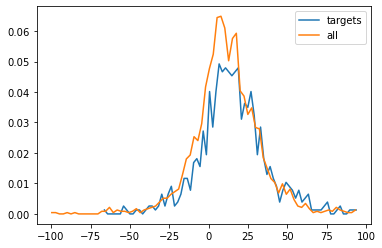

In [34]:
# evaluate the histograms
targets, base_t = np.histogram(PPP_as_table.stall_score, bins=80)
all_g, base_a = np.histogram(df.stall_score, bins=80)

#evaluate the cumulative
cumul_t = np.cumsum(targets/sum(targets))
cumul_a = np.cumsum(all_g/sum(all_g))

# plot the cumulative function
plt.plot(base_t[:-1], cumul_t, label = "targets")
plt.plot(base_a[:-1], cumul_a, label = "all")
plt.legend()
plt.show()

# A quick look at the hists
plt.plot(base_t[:-1], targets/sum(targets), label = "targets")
plt.plot(base_a[:-1], all_g/sum(all_g), label = "all")
plt.legend()

In [35]:
stats.kstest(PPP_as_table.stall_score, df.stall_score)

KstestResult(statistic=0.08538317041468582, pvalue=0.00039455991923997846)

Ok, this is a very weird task for me because it is basically requiring me to do a basic AS test rather than the weird as hell thing I was doing beforehand. 